In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import math
import sys
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from pathlib import Path
# from PIL import Image  # if you import it this way you will get attribute error, 
from PIL import Image as PilImage

from fastai.vision import *
from fastai.metrics import error_rate
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.callbacks import SaveModelCallback
%matplotlib inline

# Functions

In [3]:
# #Other
# #Body
# #List
# #HeaderFooter
# #Title
# def normalize_images(root_path, mask_folder, save_folder):
#     """ Normalizes your masks """

#     root_path = Path(r"C:\Users\payman\Desktop\Insight_Project\data\processed")
#     mask_path = root_path/'trainY_png'#Path(r"C:\Users\Rocheleau Microscope\.fastai\data\Mask Trainer\Mask\INS1E\20190307W")
#     save_path = root_path/'trainY_png_norm_3000'
#     save_path.mkdir(parents = True ,exist_ok = True)
    
#     colours = [([255,255,255], 0), # white which is background(Other) is mapped to 0
#                ([255,0,0], 1),     # red which is Body is mapped to 1
#                ([0,0,255], 2),     # blue which is List is mapped to 2
#                ([255,242,0], 3),   # yellow which is HeaderFooter is mapped to 3
#                ([0,255,0],4),      # green which is Title is mapped to 4
#           ]
#     for files in mask_path.iterdir():
#         reader = imageio.get_reader(str(files))
#         img = reader.get_data(0)
#         norm_img = np.zeros(img.shape[:2], dtype = np.uint8)
#         print(norm_img.shape)
                
#         for (colour, value) in colours:
#             r,g,b = colour
#             colours_match = np.all([img[:,:,0] == r, img[:,:,1] == g, img[:,:,2] == b], axis=0)
#             norm_img[colours_match] = value
#         imageio.imwrite(str(save_path/files.name), norm_img)
#         #print(np.amax(img))

In [4]:
def get_y_lambda_function(root_path, mask_folder = 'trainY_png_norm_3000', image_folder = 'trainX_png_3000'):
    """Step 2: Function to get the mask name from the image name"""
    return lambda filename: root_path/mask_folder/filename.relative_to(root_path/image_folder).parent/(filename.name.replace('input', 'target'))

In [5]:
""" Detemine Accuracy function"""
""" Accuracy = no. of correctly classified pixels / total no. of pixels """

""" Detemine Accuracy function"""
""" Accuracy = no. of correctly classified pixels / total no. of pixels """

def overall_acc(input_image, target):
    # shape of pred torch.Size([4, 5, 400, 400]) 4 is bs
    # shape of target(truth label) torch.Size([4, 1, 400, 400])
    target = target.squeeze(1)
    # shape of target after squeez torch.Size([4, 400, 400])
    return (input_image.argmax(dim=1)==target).float().mean()
    # the error you get if you dont use .mean(): 
    # The size of tensor a (4) must match the size of tensor b (2) at non-singleton dimension 0

# ['Other', 'Body', 'List', 'HeaderFooter', 'Title']
def Nobground_acc(input_image, target):
    target = target.squeeze(1)
    mask = target == 0
    return (input_image.argmax(dim=1)[mask]==target[mask]).float().mean()

def Body_acc(input_image, target):
    target = target.squeeze(1)
    mask = target == 1
    return (input_image.argmax(dim=1)[mask]==target[mask]).float().mean()
    
def List_acc(input_image, target):
    target = target.squeeze(1)
    mask = target == 2
    return (input_image.argmax(dim=1)[mask]==target[mask]).float().mean()

def Header_Footer_acc(input_image, target):
    target = target.squeeze(1)
    mask = target == 3
    return (input_image.argmax(dim=1)[mask]==target[mask]).float().mean()

def Title_acc(input_image, target):
    target = target.squeeze(1)
    mask = target == 4
    return (input_image.argmax(dim=1)[mask]==target[mask]).float().mean()

def isnan(z1,z2):
  return z1==z2

def List_test1(pred, target):
    target = target.squeeze(1)
    #print(channels)
    filt = target == 2
    #print(target)
    p = pred.argmax(dim=1)[filt]
    print(p)
    #t = (target[filt]).float()
    #i = p & target
    #print('shape of intersection: ',i.shape)
    #u = p | target
    #print('shape of union: ', u.shape)
    #acc = torch.div(i , u+0.0003)

    return torch.tensor([0.0])


def acc_class(channels, pred, mask):
    mask = mask.squeeze(1)
    filt = mask == channels #!= void_code
    return (pred.argmax(dim=1)[filt]==mask[filt]).float().mean()
ch_accuracies = [partial(acc_class, channels) for channels in range(5)]

# Diferent way of writing the above accuracy (fastai style)

""" fastai standard accuracy function """
def accuracy(input_image, target):
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    print('shape of input', input_image.shape)
    print('shape of target', target.shape)
    n = target.shape[0]
    print('n is batch size',n)
    input_image = input_image.argmax(dim=-1).view(n,-1)
    target = target.view(n,-1)
    print('shape of input after', input_image.shape)
    print('shape of target after target.view(n,-1) applied', target.shape)
    return (input_image==target).float().mean()
# result:
# shape of input torch.Size([4, 5, 400, 400])
# shape of target torch.Size([4, 1, 400, 400])
# n is  4
# shape of input after torch.Size([4, 2000])
# shape of target after target.view(n,-1) applied torch.Size([4, 160000])
# error:
# The size of tensor a (2000) must match the size of tensor b (160000) at non-singleton dimension 1

# Cleaning corrupted data (already executed. DO NOT RUN IT AGAIN)

In [6]:
# df= pd.read_csv(r'C:\Users\payman\Desktop\Insight_Project\data\cleaned\error_stats_errorFiles.csv')
# df.columns

In [7]:
# pdfxpath = r"/Users/payman/Desktop/Insight_Project/data/cleaned/"
# pdfypath = r"/Users/payman/Desktop/Insight_Project/data/cleaned/"

# for fnames in df['file']:
#     try:
#         os.remove(os.path.join(pdfxpath, fnames))
#     except OSError:
#         pass
    
# for fnames in df['file_target']:
#     try:
#         os.remove(os.path.join(pdfypath, fnames))   
#     except OSError:
#         pass

# Normalize the masks (already executed. DO NOT RUN IT AGAIN)

In [8]:
# """ normalize your masks"""
# normalize_images(root_path = r"C:\Users\payman\Desktop\Insight_Project\data\processed", 
#                  mask_folder = 'trainY_png_3000', 
#                  save_folder = 'trainY_png_norm_3000')

In [9]:
"""Step 1: Determine where the training images are stored
changing the resize_method in the data = block will change how the images are resized.  
Your options are ResizeMethod.SQUISH and ResizeMethod.PAD"""

root_path = Path(r"C:\Users\payman\Desktop\Insight_Project\data\processed")
seg_path = root_path/"trainX_png_3000"
codes_path = root_path/"codes.txt"
path_Inputimg = root_path/"trainX_png_3000"
path_NotNormalized_mask = root_path/"trainY_png_3000"
path_Normalized_mask = root_path/"trainY_png_norm_3000"

In [10]:
""" get the mask name from the image name """
get_mask_func = get_y_lambda_function(root_path)

In [11]:
fnames = get_image_files(path_Inputimg)
NN_mask_names = get_image_files(path_NotNormalized_mask)
N_mask_names = get_image_files(path_Normalized_mask)


In [12]:
img_f = fnames[1]
img = open_image(img_f)
#img.show(figsize=(15,15))

In [13]:
NN_mask_f = NN_mask_names[1]
NN_mask = open_mask(NN_mask_f)
#NN_mask.show(figsize=(15,15), alpha=1.)

In [14]:
N_mask_f = N_mask_names[1]
N_mask = open_mask(N_mask_f)
#N_mask.show(figsize=(15,15), alpha=1.)

In [15]:
""" Show image overlaid by the mask """
#img.show(figsize=(15,15), y= NN_mask, title='NN_Masked input')

' Show image overlaid by the mask '

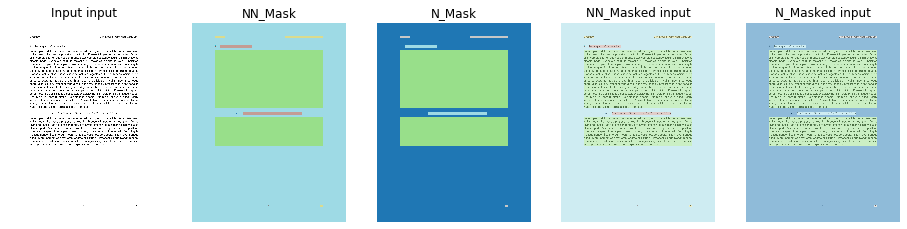

In [16]:
# you have img, NN_mask, N_mask
_, axs = plt.subplots(1,5, figsize=(16,8))
img.show(ax=axs[0], title='Input input')
NN_mask.show(ax=axs[1], title='NN_Mask', alpha=1.)
N_mask.show(ax=axs[2], title='N_Mask', alpha=1.)
img.show(ax=axs[3], y= NN_mask, title='NN_Masked input')
img.show(ax=axs[4], y= N_mask, title='N_Masked input')

In [17]:
src_size = np.array(N_mask.shape[1:])  # note that the dim must be in np array format
# src_size, N_mask.data

The fastai library includes several pretrained models from torchvision, namely:

resnet18, resnet34, resnet50, resnet101, resnet152
squeezenet1_0, squeezenet1_1
densenet121, densenet169, densenet201, densenet161
vgg16_bn, vgg19_bn
alexnet

In [18]:
""" Parameters Setting"""
lr = 2e-4                   #Learning Rate
bs = 8                      #Batch Size, with large batch sizes I ran out of memory in google Colab
size = 800 # 400                  #Size of the network (images reshaped to (sz, sz))
model = models.resnet34 #Darknet  #resnet34: 41mil params, resnet152: 373mil params    #Model 
export_name = 'MybestModel_basedOnAcc.pkl'#'RandABHome.pkl'  #Export Name
wd = 1e-3
penalty = 1
tfms = get_transforms()
tfms = [[],[]]

""" Pixel value to feature codes mapping"""
codes = np.loadtxt(codes_path, dtype = 'str')
name2id = {name:code for code, name in enumerate(codes)}
void_code = name2id['Other'] # if you use acc_not_including_background accuracy measure

In [19]:
#Note: Use ResizeMethod.PAD to pad to a square and SQUISH to squish the larger axis
# #note the tfm_y = True here. This means that whatever transform we apply on our dependent images
# # should also be applied on our target image. (Example: If we flip an image horizontally, 
# # we should also flip the corresponding labelled image

# # .label_from_func does find the labelled images using the function get_mask_func and use the codes as classes to be predicted.

def get_data(seg_path, get_mask_func, codes, tfms, size, bs):
    data = (SegmentationItemList
         .from_folder(seg_path, recurse = True)
         .split_by_rand_pct()
         .label_from_func (get_mask_func, classes = codes)
         .transform(tfms = tfms, size = size, tfm_y = True, padding_mode = 'border', resize_method = ResizeMethod.SQUISH)
         .databunch(bs = bs, num_workers = 0))
    n_classes = len(data.classes)
    return data, n_classes

In [20]:
data , nclasses= get_data(seg_path, get_mask_func, codes, tfms, size, bs)

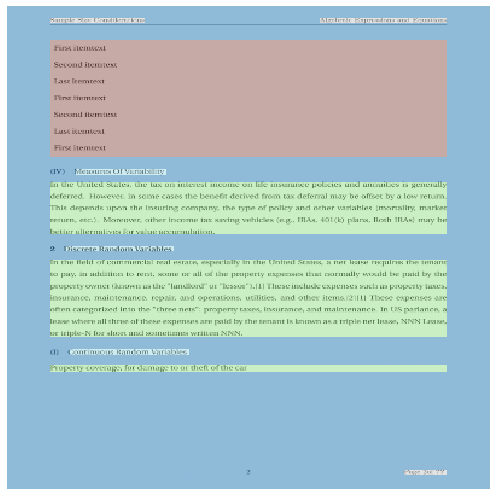

In [21]:
data.show_batch(1, figsize=(10,7))

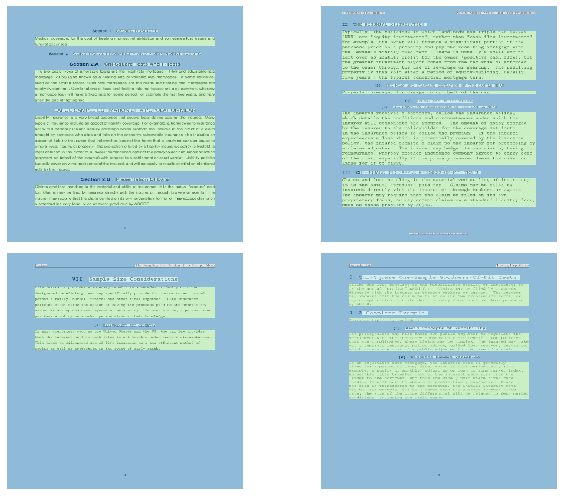

In [22]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [23]:
# """ Instantiate a Unet architecture with model (defined in params section) in encoder block """     
learn = unet_learner(data, model, wd = wd, metrics = [Nobground_acc, Body_acc, List_acc, Header_Footer_acc , Title_acc])# [ *ch_accuracies])
#                  #loss_func = CrossEntropyFlat(axis=1, weight = torch.FloatTensor([1,penalty]).cuda())

In [24]:
learn.summary()

In [ ]:
def extract_all_layers(sequence, layers = []):
    for child in sequence.children():
        if isinstance(child, nn.Sequential): layers = extract_all_layers(child, layers)
        else: layers.append(child)
    return layers

lls = extract_all_layers(learn.model)

# Train the model with most of the layers frozen

In [25]:
# """Find the appropriate learning rate by choosing an area of continuous descent"""
learn.lr_find()
learn.recorder.plot()

In [26]:
data.show_batch()

In [27]:
learn.fit_one_cycle(5, max_lr = lr, callbacks=[SaveModelCallback(learn, every='epoch', monitor=[Nobground_acc])])

In [28]:
learn.export(r"C:\Users\payman\Desktop\Insight_Project\data\PICKEL_FILES\shortCycle_best_model.pkl")

In [29]:
learn.show_results()

# Next unfreeze the rest of the layers and retrain using a new learning rate

In [30]:
""" unfreeze the layers to make all params trainable """
learn.unfreeze()

In [31]:
# """ Choose a new learning rate to optimize training"""
learn.lr_find(start_lr = 1e-4)
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(10, max_lr = lr, callbacks=[SaveModelCallback(learn, every='epoch', monitor=[Nobground_acc], name='bestmodel')])

In [33]:
# learn.show_results()

learn.export is used to export your learner and all its related parts (transforms, metrics,…). It’s usually what you want when you’re putting your model out for production.
The callback SaveModelCallback 3 periodically saves your learner object while training. By default it saves the model with the best val_loss and saves it as bestmodel. It simply uses the regular learn.save to save your model weights. You could then export this model for inference using:
#learn.load('bestmodel'), then export it.
#learn.export(r"mybestmodel.pkl")

In [34]:
learn.export(r"C:\Users\payman\Desktop\Insight_Project\data\PICKEL_FILES\SomeName.pkl")

# Import the pretrained model (arch&weigths) for prediction

In [35]:
imported_learn = load_learner(r"C:\Users\payman\Desktop\Insight_Project\data\PICKEL_FILES", "10epochs_best_model_3000sample_size400.pkl", num_workers = 0)

# Functions for Test Stage

In [36]:
root_path = Path(r"C:\Users\payman\Desktop\Insight_Project\data\processed")
test_path = root_path/'Test_set'
output_path = r"C:\Users\payman\Desktop\Insight_Project\data\processed\Test_set_outputs"

def path2testfiles_list(test_path):
    """ Create the list of file names present in Test_set """
    xPath = []
    for files in test_path.iterdir():
        xPath.append(str(files))
    return xPath


def make_test_dir(output_path, xPath):
    """ for each testfile in xPath create a directory for it in Test_set_outputs directory """
    for d in range(len(xPath)):    
        testfile_name = os.path.split(xPath[d])
        fname = os.path.splitext(str(testfile_name[1]))[0]
        dir = os.path.join(output_path, fname)
        if not os.path.exists(dir):
            os.mkdir(dir)

def get_nppreds_list(xPath):
    """ Predict the output of each file in Test_set, convert them to nparrays, and place them in a list """
    nppred_list = [] # list of np arrays associated with your test images(eg, you are testing 4 images)
    for i in range(len(xPath)):
        im = open_image(xPath[i]) # channel, hight, width
        pred = imported_learn.predict(im)[0] # (W, H), pixel values are indexes of your classes
        p = pred.data.numpy() # converted to np array, pixel values are indexes of your classes (0,1,2,...)
        nppred_list.append(p)
    return nppred_list


def trans_reshape_nppreds(nppred_list):  
    """ Reshape the nparray predictions from (C, H, W) to (W, H, C)  """
    reshaped_nppred_list = []
    for i in range(len(nppred_list)):
        test_p = nppred_list[i].transpose(2,1,0) # from (C, H, W) to (W, H, C) 
        test_p = test_p.reshape((400,400))       # reshape to (W, H) ie (pred.size[0], pred.size[1])
        reshaped_nppred_list.append(test_p)
    return reshaped_nppred_list

def save_pred_classes_2_dirs(codes, xPath, output_path, reshaped_nppred_list):
    """ Extract the text from each class, from each image in Test_set, place them in their dir in Test_set_outputs """
    for ind, name in enumerate(codes):
        for n in range(len(xPath)): # lets do it for one image in xPath first then len(xPath)
            imgx = PilImage.open(xPath[n]) # PIL open the image in (W, H)
            imgx = imgx.resize((400,400)) # ie resize to (W, H) which is (pred.size[0], pred.size[1])
            pixelsx = imgx.load()         # load the pixel map of the original image
            for i in range(imgx.size[0]): # width index
                for j in range(imgx.size[1]):  # height imdex
                    if reshaped_nppred_list[n][i,j] != ind: #array(['Other', 'Body', 'List', 'HeaderFooter', 'Title']
                        pixelsx[i,j] = (255, 255 ,255) 
                    # whiteout everything in orig image that its corresponding pixel in pred is not the above class
            #imgx.show()
            n = os.path.split(xPath[n])
            fname = os.path.splitext(str(n[1]))[0]
            dumypath2 = os.path.join(output_path,fname)
            imageio.imwrite(str(dumypath2+'/{}.png'.format(name)), imgx)
            imgx.close()

# Function executions for Test Stage

In [37]:
xPath= path2testfiles_list(test_path)    
make_test_dir(output_path, xPath)
nppred_list = get_nppreds_list(xPath)
reshaped_nppred_list = trans_reshape_nppreds(nppred_list)
save_pred_classes_2_dirs(codes, xPath, output_path, reshaped_nppred_list)